# Agnew and McGarry replication with npgamma

The tests given here are replicated using npgamma from the method given within the following paper:

 > C. Agnew, C. McGarry, *A tool to include gamma analysis software into a quality assurance program*. Radiotherapy and Oncology (2016), http://dx.doi.org/10.1016/j.radonc.2015.11.034

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

import dicom
from glob import glob
import re

from npgamma import calc_gamma

In [2]:
file_list = glob("agnew_mcgarry_images/*.dcm")
dcm = dict()
file_names = [
    re.search('^agnew_mcgarry_images/(.*).dcm$', item).group(1)
    for item in file_list]
for key in file_names:
    dcm[key] = dicom.read_file("agnew_mcgarry_images/{}.dcm".format(key))

file_names  

['GeometricSquare_Evaluated_0_25mmPx_DD_Test',
 'GeometricSquare_Reference_1mmPx',
 'ProstateIMRT_Reference_0_25mmPx',
 'GeometricSquare_Evaluated_0_25mmPx_DTA_Test',
 'ProstateIMRT_Evaluated_1mmPx',
 'GeometricSquare_Evaluated_1mmPx_DD_Test',
 'H&N_VMAT_Reference_1mmPx',
 'ProstateIMRT_Evaluated_0_25mmPx',
 'H&N_VMAT_Evaluated_0_25mmPx',
 'ProstateIMRT_Reference_1mmPx',
 'H&N_VMAT_Evaluated_1mmPx',
 'GeometricSquare_Evaluated_1mmPx_DTA_Test',
 'H&N_VMAT_Reference_0_25mmPx',
 'GeometricSquare_Reference_0_25mmPx']

In [3]:
def load_dose_from_dicom(dcm):
    pixels = dcm.pixel_array
    dose = pixels * dcm.DoseGridScaling

    return dose


def load_yx_from_dicom(dcm):
    resolution = np.array(
        dcm.PixelSpacing).astype(float)
    dx = resolution[0]
    x = (
        dcm.ImagePositionPatient[0] +
        np.arange(0, dcm.Columns * dx, dx))

    dy = resolution[1]
    y = (
        dcm.ImagePositionPatient[1] +
        np.arange(0, dcm.Rows * dy, dy))

    return y, x


dose = dict()
coords = dict()
for key in file_names:
    dose[key] = load_dose_from_dicom(dcm[key])
    coords[key] = load_yx_from_dicom(dcm[key])

# Display all files checking for axis definition consistency

In [4]:
def display_file(key):
    x = coords[key][1]
    y = coords[key][0]
    pixel_value = dose[key]
    
    dx = x[1] - x[0]
    x_pcolor = np.arange(x[0]-dx/2, x[-1] + dx, dx)

    dy = y[1] - y[0]
    y_pcolor = np.arange(y[0]-dy/2, y[-1] + dy, dy)
    
    plt.figure()
    plt.pcolormesh(
        x_pcolor, y_pcolor, pixel_value)
    plt.colorbar()
    plt.gca().invert_yaxis()
    plt.axis('equal')
    plt.title(key)

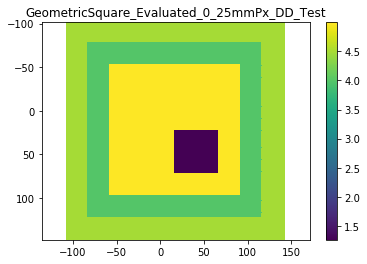

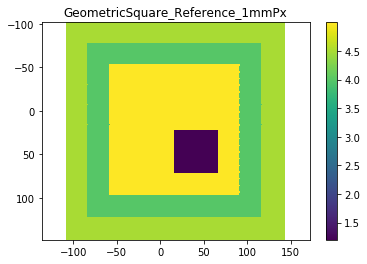

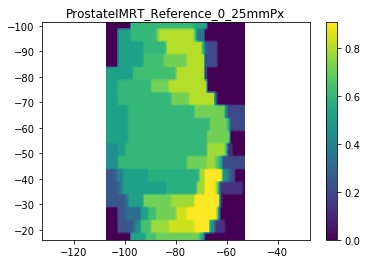

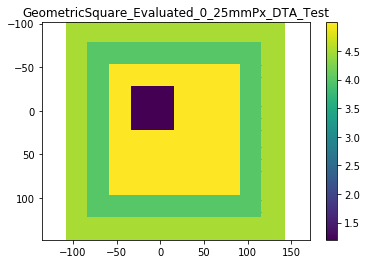

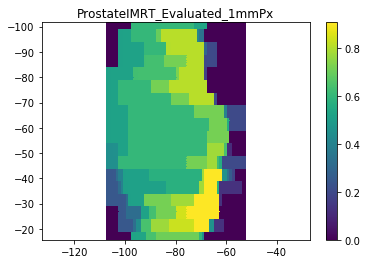

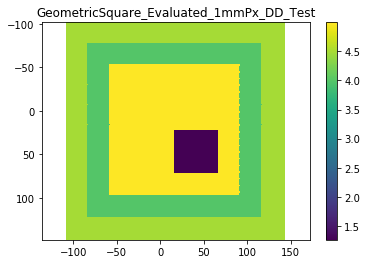

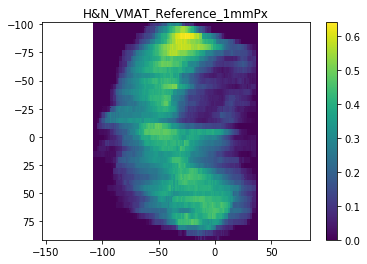

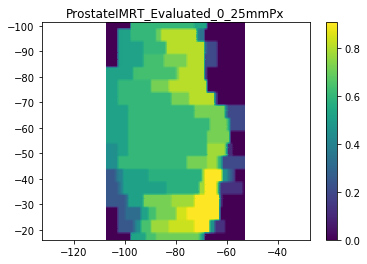

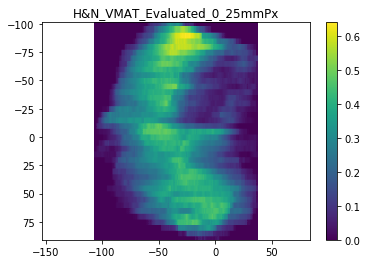

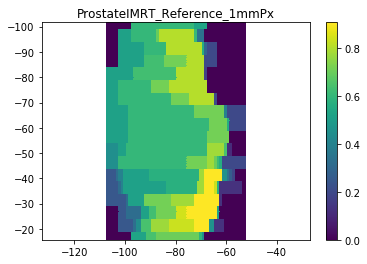

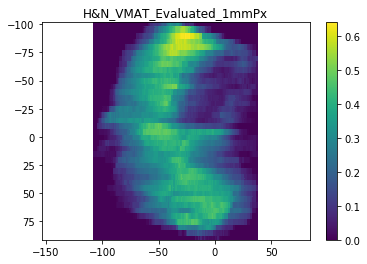

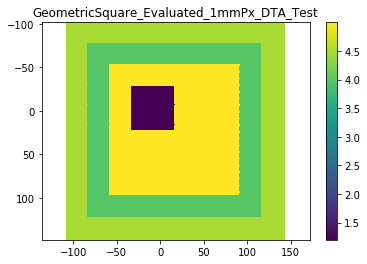

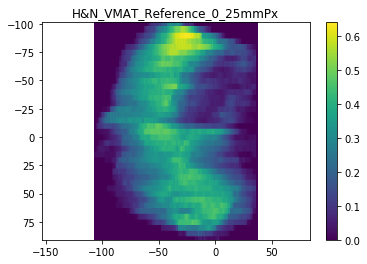

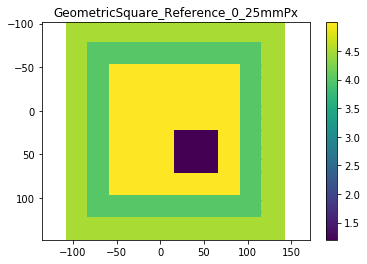

In [5]:
for key in file_names:
    display_file(key)

# Tests prep

In [6]:
def display_gamma_result(coords, gamma):
    valid_gamma = gamma[~np.isnan(gamma)]
    valid_gamma[valid_gamma > 2] = 2
    
    x_evaluation = coords[1]
    y_evaluation = coords[0]

    dx = x_evaluation[1] - x_evaluation[0]
    x_pcolor = np.arange(x_evaluation[0]-dx/2, x_evaluation[-1] + dx, dx)

    dy = y_evaluation[1] - y_evaluation[0]
    y_pcolor = np.arange(y_evaluation[0]-dy/2, y_evaluation[-1] + dy, dy)

    cut_off_gamma = np.ma.array (gamma, mask=np.isnan(gamma))
    cmap = cm.bwr
    cmap.set_bad('white',1.)
    
    plt.figure()
    plt.pcolormesh(
        x_pcolor, y_pcolor, cut_off_gamma, cmap=cmap, vmin=0, vmax=2)

    plt.gca().invert_yaxis()
    plt.axis('equal')
    plt.colorbar()
    
    plt.figure()
    plt.hist(valid_gamma, 30);
    plt.xlim([0,2])
    
    gamma_pass = np.sum(valid_gamma <= 1) / len(valid_gamma)
    print('Gamma pass rate = {}%'.format(gamma_pass*100))

In [7]:
def run_tests(ref_keys, eval_keys, thresholds):
    for i in range(len(ref_keys)):
        ref_key = ref_keys[i]
        print("Reference = {}".format(ref_key))
        display_file(ref_key)
        plt.show()
        
        eval_key = eval_keys[i]
        print("Evaluation = {}".format(eval_key))
        display_file(eval_key)
        plt.show()
        
        max_dose = np.max(dose[ref_key])
        print("Max Dose = {}".format(max_dose))
        
        distance_threshold = thresholds
        distance_step_size = 0.025
        dose_threshold = thresholds * 0.01 * max_dose
        lower_dose_cutoff = max_dose * 0.1
        maximum_test_distance = thresholds * 2

        gamma = calc_gamma(
            coords[ref_key], 
            dose[ref_key],
            coords[eval_key], 
            dose[eval_key],
            distance_threshold, dose_threshold,
            lower_dose_cutoff=lower_dose_cutoff, 
            distance_step_size=distance_step_size,
            maximum_test_distance=maximum_test_distance, num_threads=4)

        display_gamma_result(
            coords[eval_key],
            gamma)
        plt.show()

# Geometric DTA test

Reference = GeometricSquare_Reference_0_25mmPx


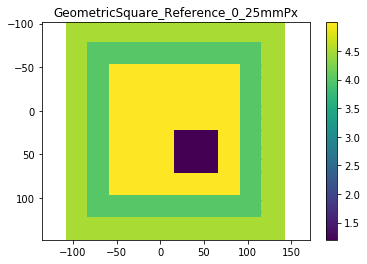

Evaluation = GeometricSquare_Evaluated_0_25mmPx_DTA_Test


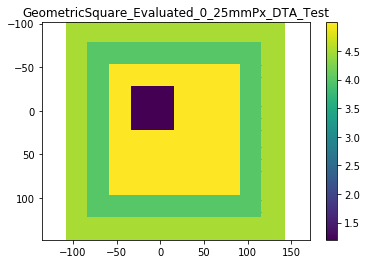

Max Dose = 4.999992825
Gamma pass rate = 92.19041276286231%


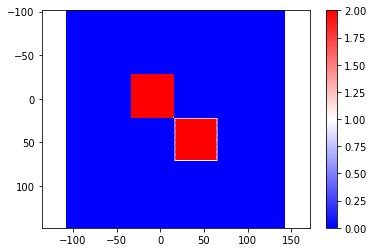

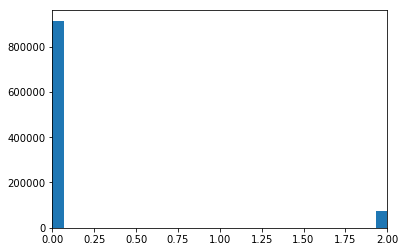

Reference = GeometricSquare_Reference_1mmPx


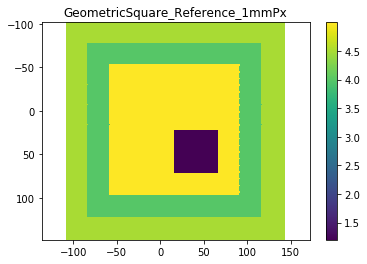

Evaluation = GeometricSquare_Evaluated_1mmPx_DTA_Test


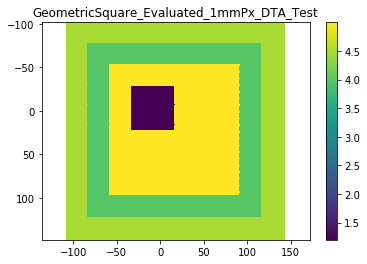

Max Dose = 4.999992825
Gamma pass rate = 92.0%


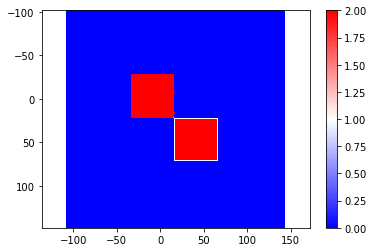

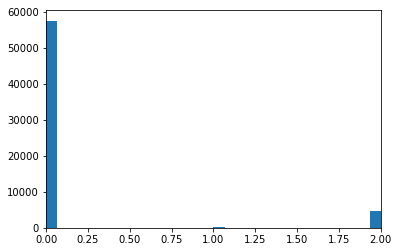

In [8]:
ref_keys = [
    'GeometricSquare_Reference_0_25mmPx',
    'GeometricSquare_Reference_1mmPx',]

eval_keys = [
    'GeometricSquare_Evaluated_0_25mmPx_DTA_Test',
    'GeometricSquare_Evaluated_1mmPx_DTA_Test']        
        
run_tests(ref_keys, eval_keys, thresholds=1)

# Geometric DD test

Reference = GeometricSquare_Reference_0_25mmPx


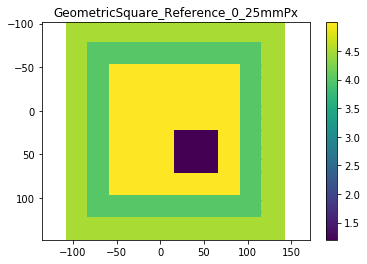

Evaluation = GeometricSquare_Evaluated_0_25mmPx_DD_Test


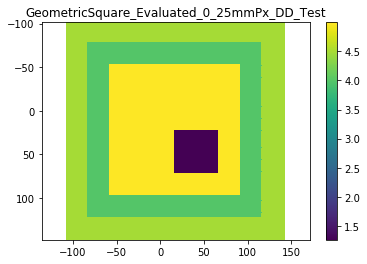

Max Dose = 4.999992825
Gamma pass rate = 96.2527502266076%


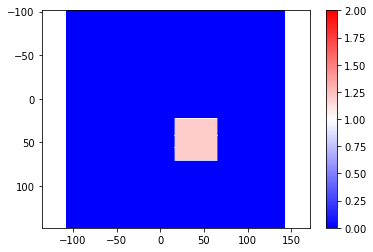

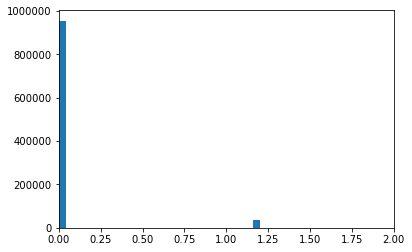

Reference = GeometricSquare_Reference_1mmPx


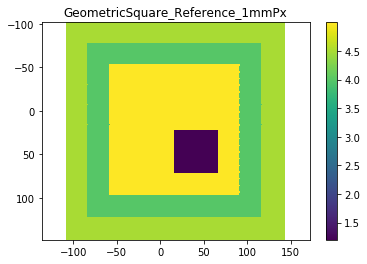

Evaluation = GeometricSquare_Evaluated_1mmPx_DD_Test


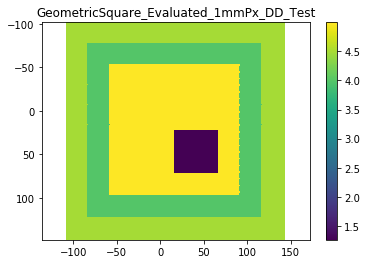

Max Dose = 4.999992825
Gamma pass rate = 96.3136%


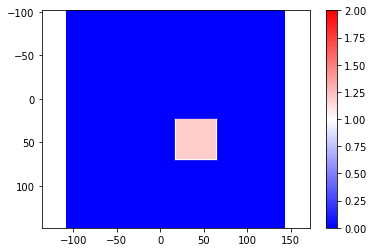

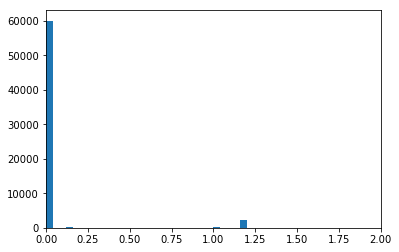

In [9]:
ref_keys = [
    'GeometricSquare_Reference_0_25mmPx',
    'GeometricSquare_Reference_1mmPx',]
    
eval_keys = [
    'GeometricSquare_Evaluated_0_25mmPx_DD_Test',
    'GeometricSquare_Evaluated_1mmPx_DD_Test']        
        
run_tests(ref_keys, eval_keys, thresholds=1)

# Simple prostate IMRT 3% and 3mm

Reference = ProstateIMRT_Reference_0_25mmPx


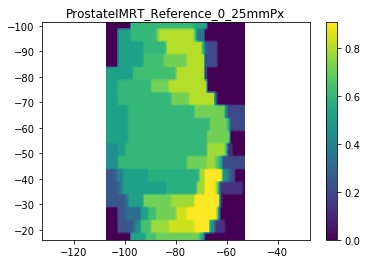

Evaluation = ProstateIMRT_Evaluated_0_25mmPx


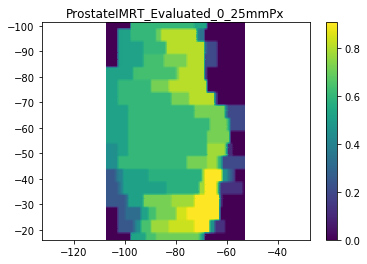

Max Dose = 0.907332075
Gamma pass rate = 100.0%


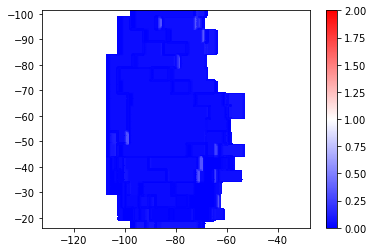

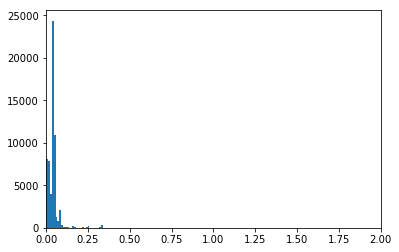

Reference = ProstateIMRT_Reference_1mmPx


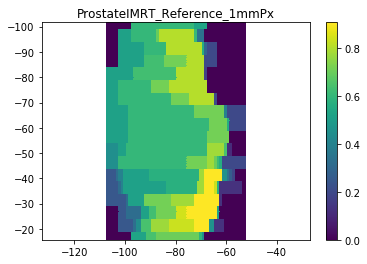

Evaluation = ProstateIMRT_Evaluated_1mmPx


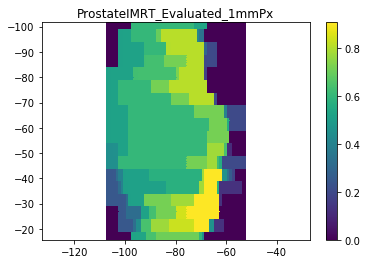

Max Dose = 0.907332075
Gamma pass rate = 100.0%


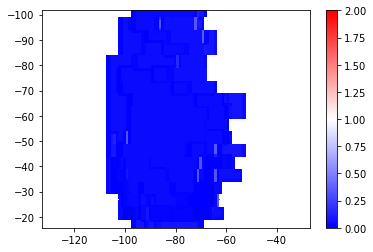

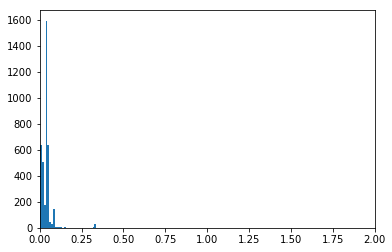

In [10]:
ref_keys = [
    'ProstateIMRT_Reference_0_25mmPx',
    'ProstateIMRT_Reference_1mmPx',]
    
eval_keys = [
    'ProstateIMRT_Evaluated_0_25mmPx',
    'ProstateIMRT_Evaluated_1mmPx']        
        
run_tests(ref_keys, eval_keys, thresholds=3)

# Simple prostate IMRT 1% and 1mm

Reference = ProstateIMRT_Reference_0_25mmPx


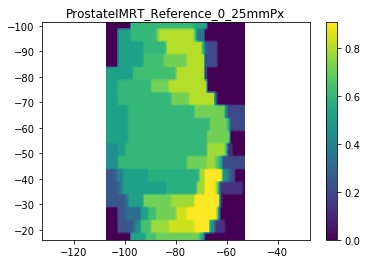

Evaluation = ProstateIMRT_Evaluated_0_25mmPx


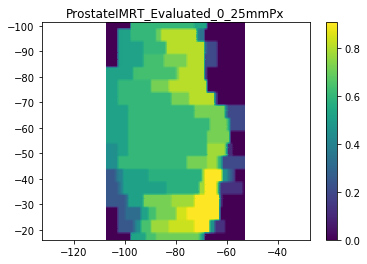

Max Dose = 0.907332075
Gamma pass rate = 99.66774146030083%


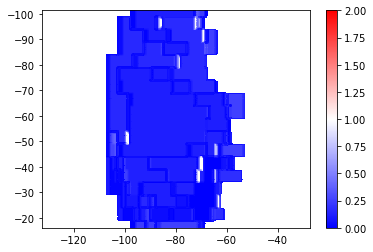

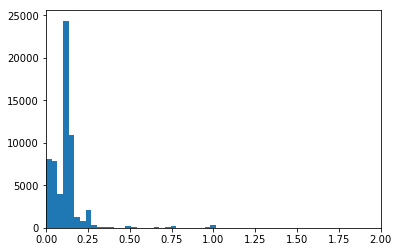

Reference = ProstateIMRT_Reference_1mmPx


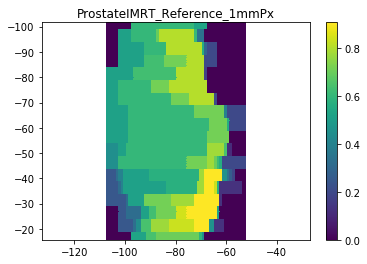

Evaluation = ProstateIMRT_Evaluated_1mmPx


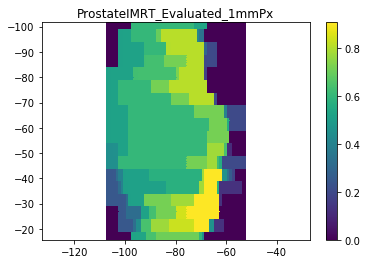

Max Dose = 0.907332075
Gamma pass rate = 99.24518479958355%


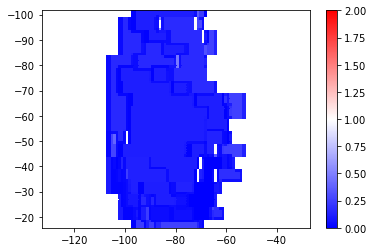

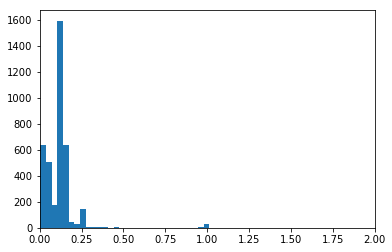

In [11]:
ref_keys = [
    'ProstateIMRT_Reference_0_25mmPx',
    'ProstateIMRT_Reference_1mmPx',]
    
eval_keys = [
    'ProstateIMRT_Evaluated_0_25mmPx',
    'ProstateIMRT_Evaluated_1mmPx']        
        
run_tests(ref_keys, eval_keys, thresholds=1)

# Complex head and neck VMAT arc 3% and 3mm

Reference = H&N_VMAT_Reference_0_25mmPx


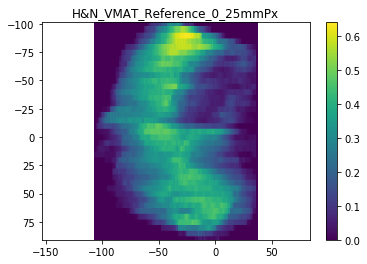

Evaluation = H&N_VMAT_Evaluated_0_25mmPx


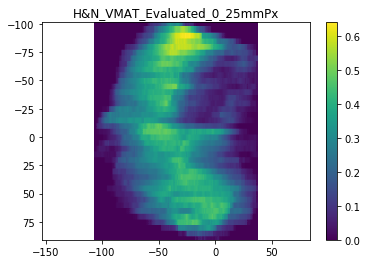

Max Dose = 0.639775767
Gamma pass rate = 100.0%


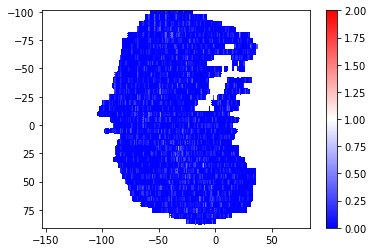

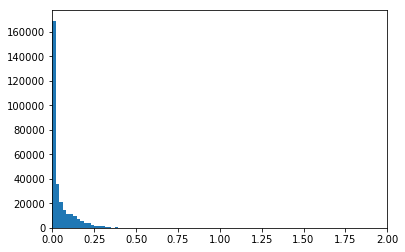

Reference = H&N_VMAT_Reference_1mmPx


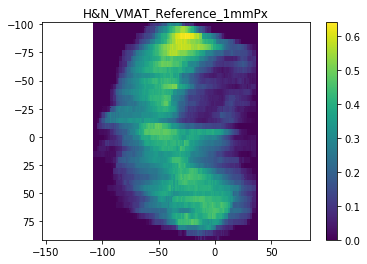

Evaluation = H&N_VMAT_Evaluated_1mmPx


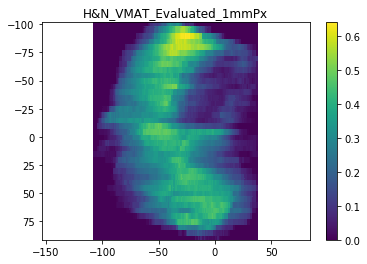

Max Dose = 0.639775767
Gamma pass rate = 100.0%


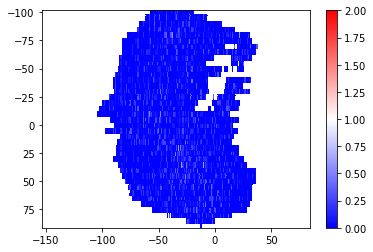

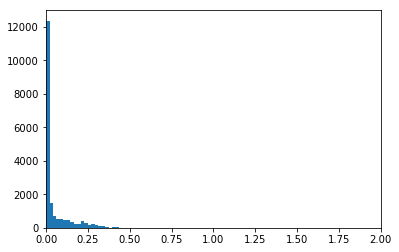

In [12]:
ref_keys = [
    'H&N_VMAT_Reference_0_25mmPx',
    'H&N_VMAT_Reference_1mmPx',]
    
eval_keys = [
    'H&N_VMAT_Evaluated_0_25mmPx',
    'H&N_VMAT_Evaluated_1mmPx']        
        
run_tests(ref_keys, eval_keys, thresholds=3)

# Complex head and neck VMAT arc 1% and 1mm

Reference = H&N_VMAT_Reference_0_25mmPx


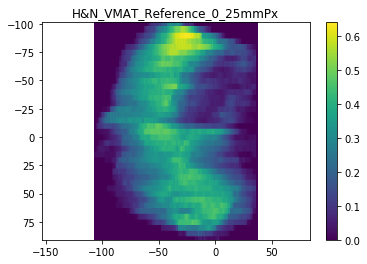

Evaluation = H&N_VMAT_Evaluated_0_25mmPx


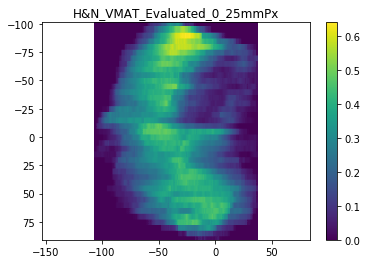

Max Dose = 0.639775767
Gamma pass rate = 99.42721329391858%


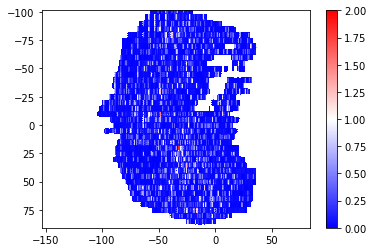

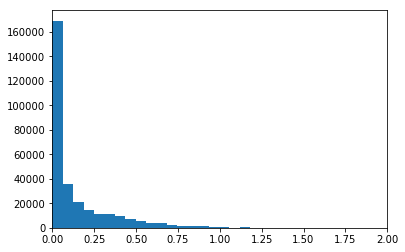

Reference = H&N_VMAT_Reference_1mmPx


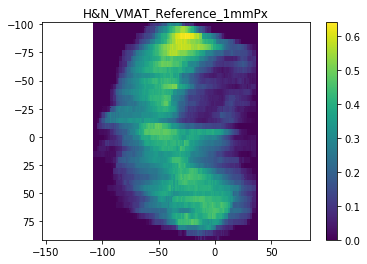

Evaluation = H&N_VMAT_Evaluated_1mmPx


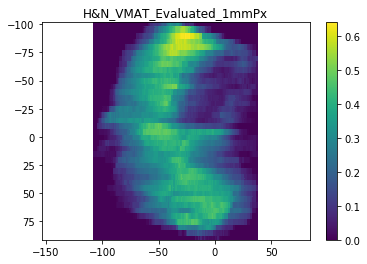

Max Dose = 0.639775767
Gamma pass rate = 98.85542486418059%


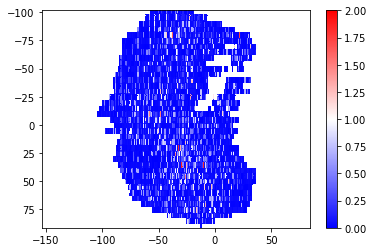

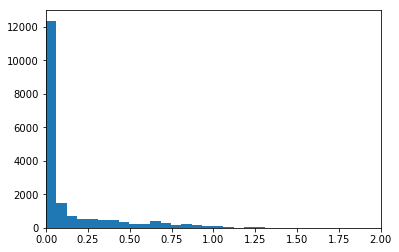

In [13]:
ref_keys = [
    'H&N_VMAT_Reference_0_25mmPx',
    'H&N_VMAT_Reference_1mmPx',]
    
eval_keys = [
    'H&N_VMAT_Evaluated_0_25mmPx',
    'H&N_VMAT_Evaluated_1mmPx']        
        
run_tests(ref_keys, eval_keys, thresholds=1)